In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [8]:
path = Path('/home/nihargajre/datasets/planet')

In [12]:
!ls {path}

__MACOSX		      submission1.256.resnet34.csv  train_v2.csv
models			      test-jpg			    train_v2.csv.zip
sample_submission_v2.csv      tmp
sample_submission_v2.csv.zip  train-jpg


In [13]:
df = pd.read_csv(path / 'train_v2.csv')

In [14]:
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [15]:
xforms = get_transforms(flip_vert=True,
                        max_lighting=0.1,
                        max_zoom=1.05, max_warp=0.0)

In [17]:
# Make notebook reproducible
np.random.seed(42)

In [20]:
src = ImageFileList.from_folder(path).label_from_csv('train_v2.csv', sep=' ',
                                    folder='train-jpg', suffix='.jpg').random_split_by_pct(0.2)

In [22]:
data = src.datasets().transform(xforms, size=128)\
                    .databunch()\
                    .normalize(imagenet_stats)

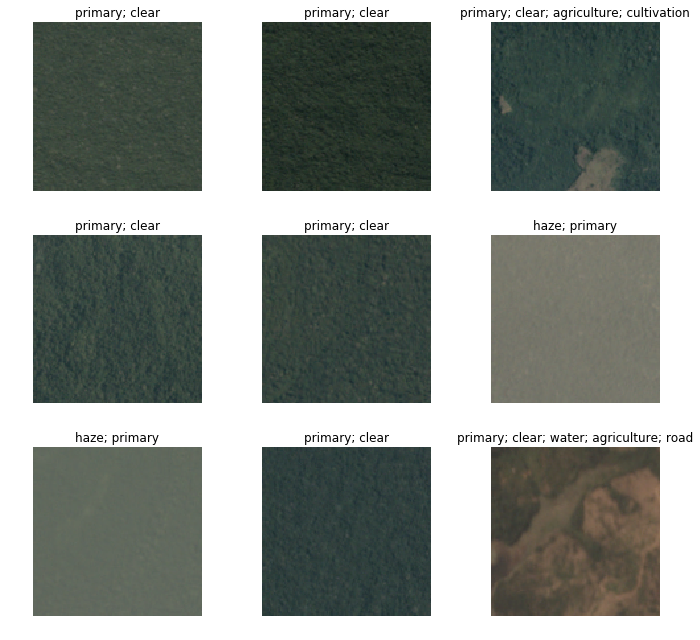

In [24]:
data.show_batch(rows=3, figsize=(10, 9))

In [26]:
arch = models.resnet50

In [28]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f2_score = partial(fbeta, thresh=0.2)

learn = create_cnn(data, arch=arch, metrics=[acc_02, f2_score])

In [29]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


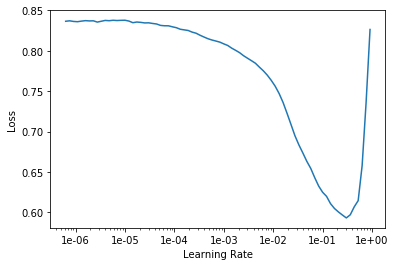

In [30]:
learn.recorder.plot()

In [31]:
lr = 0.01

In [32]:
learn.fit_one_cycle(5, slice(lr))

Total time: 08:54
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.116742    0.104387    0.950587         0.910178  (02:52)
2      0.108711    0.096936    0.950572         0.916721  (01:29)
3      0.101253    0.092069    0.954140         0.920904  (01:32)
4      0.093342    0.086676    0.958006         0.925703  (01:29)
5      0.088196    0.084579    0.957803         0.927066  (01:30)



In [33]:
learn.save('stage-1-resnet50')

In [34]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


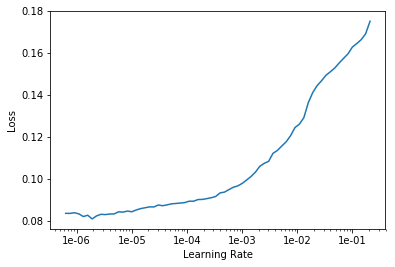

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 07:44
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.094773    0.088472    0.955521         0.924821  (01:33)
2      0.092738    0.089653    0.954641         0.921455  (01:32)
3      0.092288    0.085170    0.955346         0.927074  (01:32)
4      0.085208    0.082833    0.958733         0.929155  (01:34)
5      0.082175    0.082209    0.957614         0.928299  (01:32)



In [37]:
learn.save('stage-2-resnet50')

In [38]:
data = src.datasets(ImageMultiDataset).transform(xforms, size=256)\
          .databunch().normalize(imagenet_stats)

In [39]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [40]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


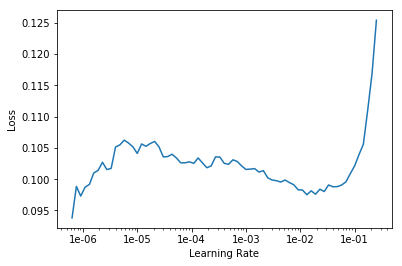

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
lr = 1e-3 * 2

In [44]:
learn.fit_one_cycle(5, slice(lr))

Total time: 14:29
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.085604    0.085025    0.957490         0.926001  (02:54)
2      0.085554    0.082848    0.958101         0.928647  (02:53)
3      0.084277    0.081452    0.957897         0.929576  (02:53)
4      0.080576    0.081373    0.959271         0.930200  (02:54)
5      0.084128    0.081079    0.959670         0.931309  (02:53)



In [45]:
learn.save('stage-1-256-resnet50')

In [46]:
learn.unfreeze()

In [47]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 18:51
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.081505    0.081834    0.959329         0.929947  (03:46)
2      0.083672    0.083713    0.959445         0.927485  (03:46)
3      0.081388    0.081291    0.958674         0.930986  (03:45)
4      0.078552    0.080493    0.958435         0.930444  (03:47)
5      0.078133    0.080459    0.960251         0.931681  (03:45)



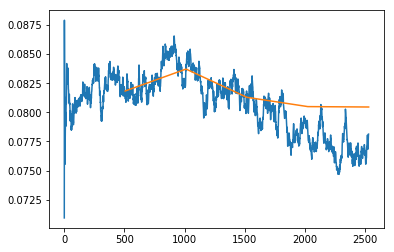

In [48]:
learn.recorder.plot_losses()

In [49]:
learn.save('stage-2-256-resnet50')